# Example CV3 - Function fitting with a quantum neural network

In this example we show how a variational circuit can be used to learn a fit for a one-dimensional function when being trained with noisy samples from that function. 

The variational circuit we use is the continuous-variable quantum neural network model described in [Killoran et al. (2018)](https://arxiv.org/abs/1806.06871). 

### Imports

We import PennyLane, the wrapped version of NumPy provided by PennyLane, and an optimizer. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

The device we use is the Strawberry Fields simulator, this time with only one quantum mode (or `wire`). You will need to have the Strawberry Fields plugin for PennyLane installed.

In [2]:
try:
    dev = qml.device('strawberryfields.fock', wires=1, cutoff_dim=10)    
except:
    print("To run this demo you need to install the strawberryfields plugin...")

### Quantum node

For a single quantum mode, each layer of the variational circuit is defined as:

In [3]:
def layer(v):

    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0., wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0., wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into the displacement of the mode, and then executes the layers. The output is the expectation of the x-quadrature.

In [4]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    
    # Encode input x into quantum state
    qml.Displacement(x, 0., wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval.X(0)

### Objective

As an objective we take the square loss between target labels and model predictions.

In [5]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)

    return loss

In the cost function, we compute the outputs from the variational circuit. Function fitting is a regression problem, and we interpret the expectations from the quantum node as predictions (i.e., without applying postprocessing such as thresholding).

In [6]:
def cost(var, features, labels):

    preds = [quantum_neural_net(var, x=x) for x in features]

    return square_loss(labels, preds)

### Optimization

We load noisy data samples of a sine function.

In [7]:
data = np.loadtxt("data/sine.txt")
X = data[:, 0]
Y = data[:, 1]

Before training a model, let's examine the data.

*Note: For the next cell to work you need the matplotlib library.* 

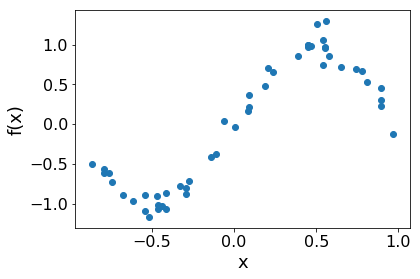

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.scatter(X, Y)
plt.xlabel('x', fontsize=18)
plt.ylabel('f(x)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

The network's weights (called `var` here) are initialized with values sampled from a normal distribution. We use 4 layers; performance has been found to plateau at around 6 layers.

In [9]:
np.random.seed(0)
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 7)

var_init

array([[ 0.08820262,  0.02000786,  0.0489369 ,  0.11204466,  0.0933779 ,
        -0.04886389,  0.04750442],
       [-0.00756786, -0.00516094,  0.02052993,  0.00720218,  0.07271368,
         0.03805189,  0.00608375],
       [ 0.02219316,  0.01668372,  0.07470395, -0.01025791,  0.01565339,
        -0.04270479, -0.12764949],
       [ 0.03268093,  0.04322181, -0.03710825,  0.11348773, -0.07271828,
         0.00228793, -0.00935919]])

Using the Adam optimizer, we update the weights for 500 steps (this takes some time). More steps will lead to a better fit.

In [10]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(500):
    var = opt.step(lambda v: cost(v, X, Y), var)
    
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X, Y)))

Iter:     1 | Cost: 0.4358370 
Iter:     2 | Cost: 0.3968726 
Iter:     3 | Cost: 0.3657283 
Iter:     4 | Cost: 0.3394391 
Iter:     5 | Cost: 0.3166425 
Iter:     6 | Cost: 0.2965857 
Iter:     7 | Cost: 0.2788022 
Iter:     8 | Cost: 0.2629771 
Iter:     9 | Cost: 0.2488823 
Iter:    10 | Cost: 0.2363415 
Iter:    11 | Cost: 0.2252100 
Iter:    12 | Cost: 0.2153628 
Iter:    13 | Cost: 0.2066864 
Iter:    14 | Cost: 0.1990745 
Iter:    15 | Cost: 0.1924251 
Iter:    16 | Cost: 0.1866387 
Iter:    17 | Cost: 0.1816178 
Iter:    18 | Cost: 0.1772668 
Iter:    19 | Cost: 0.1734926 
Iter:    20 | Cost: 0.1702055 
Iter:    21 | Cost: 0.1673197 
Iter:    22 | Cost: 0.1647548 
Iter:    23 | Cost: 0.1624365 
Iter:    24 | Cost: 0.1602975 
Iter:    25 | Cost: 0.1582787 
Iter:    26 | Cost: 0.1563290 
Iter:    27 | Cost: 0.1544061 
Iter:    28 | Cost: 0.1524765 
Iter:    29 | Cost: 0.1505153 
Iter:    30 | Cost: 0.1485056 
Iter:    31 | Cost: 0.1464381 
Iter:    32 | Cost: 0.1443101 
Iter:   

Iter:   266 | Cost: 0.0157747 
Iter:   267 | Cost: 0.0157253 
Iter:   268 | Cost: 0.0156768 
Iter:   269 | Cost: 0.0156291 
Iter:   270 | Cost: 0.0155823 
Iter:   271 | Cost: 0.0155362 
Iter:   272 | Cost: 0.0154910 
Iter:   273 | Cost: 0.0154466 
Iter:   274 | Cost: 0.0154029 
Iter:   275 | Cost: 0.0153600 
Iter:   276 | Cost: 0.0153179 
Iter:   277 | Cost: 0.0152765 
Iter:   278 | Cost: 0.0152358 
Iter:   279 | Cost: 0.0151958 
Iter:   280 | Cost: 0.0151566 
Iter:   281 | Cost: 0.0151180 
Iter:   282 | Cost: 0.0150801 
Iter:   283 | Cost: 0.0150429 
Iter:   284 | Cost: 0.0150063 
Iter:   285 | Cost: 0.0149704 
Iter:   286 | Cost: 0.0149351 
Iter:   287 | Cost: 0.0149004 
Iter:   288 | Cost: 0.0148663 
Iter:   289 | Cost: 0.0148328 
Iter:   290 | Cost: 0.0147999 
Iter:   291 | Cost: 0.0147676 
Iter:   292 | Cost: 0.0147359 
Iter:   293 | Cost: 0.0147047 
Iter:   294 | Cost: 0.0146740 
Iter:   295 | Cost: 0.0146439 
Iter:   296 | Cost: 0.0146143 
Iter:   297 | Cost: 0.0145853 
Iter:   

Finally, we collect the predictions of the trained model for 50 values in the range $[-1,1]$...

In [11]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

...and plot the shape of the function that the model has "learned" from the noisy data (green dots).

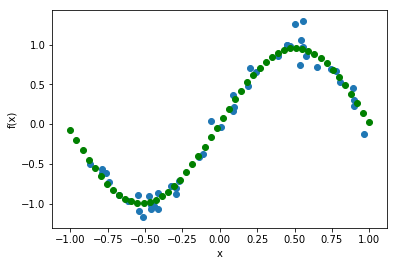

In [12]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color='green')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()

The model has learned to smooth the noisy data.

In fact, we can use PennyLane to look at typical functions that the model produces without being trained at all. The shape of these functions varies significantly with the variance hyperparameter for the weight initialization. 

Setting this hyperparameter to a small value produces almost linear functions, since all quantum gates in the variational circuit approximately perform the identity transformation in that case. Larger values produce smoothly oscillating functions with a period that depends on the number of layers used (generically, the more layers, the smaller the period).

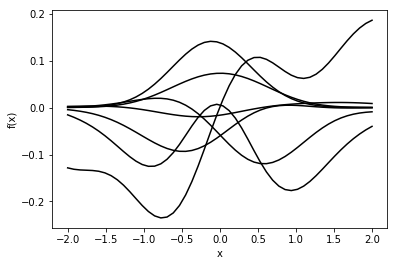

In [13]:
variance = 1.

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color='black')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()